In [41]:
# import necessary packages
import os
import pandas
import numpy
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
# import function for querying DOE dataframes
from monte_carlo_utils import get_DOE_atb



# set file location and name
atb_shp_path = Path('/data/MIDOSS/shapefiles/atb_2018_01.shp')
mmsi_xls_path = Path('/data/MIDOSS/spreadsheets/ATB_MMSIs.xlsx')
doe_xls_path = Path('/data/MIDOSS/spreadsheets/MuellerTrans4-30-20.xlsx')
fac_xls_path = Path(
    '/home/rmueller/Projects/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx'
)

# import shapefile using geopandas
atb_shp = gpd.read_file(atb_shp_path)

# import facility locations
facWA = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'Washington',
    usecols="B,D,J,K"
)
facBC = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'British Columbia',
    usecols="A,B,C"
)
# view  the top 6 lines of attribute table of data
atb_shp.head(1)

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
0,316001223.0,2018-01-01 00:03:48,2018-01-01 00:05:58,41,US,US,"LINESTRING (-122.77574 48.33663, -122.77796 48..."


In [2]:
# create list of names and MMSI from "Top_six_ATBs_by_DOEtransfers.xlsx"
# NOTE: Island Trader has 3 possible MMSI.  Exploring all three options
MMSI_names = ['ALL ABOARD FOR A CURE','DBL 185','ISLAND TRADER',
              '550-2','ONEDREAM',
              'ISLAND TRADER','ISLAND TRADER']
MMSI_list = [368013040, 338616000, 316001221, 369580000, 367740790,316001223,316006101]
MMSI_colors = ['indigo','olive','lightseagreen',
               'darkgoldenrod','royalblue',
               'mediumturquoise','mediumaquamarine']
# create dictionary linking MMSI to barge name
MMSI_dict = {MMSI_list[num]:MMSI_names[num] for num,name in enumerate(MMSI_names)}
color_dict = {MMSI_list[num]:MMSI_colors[num] for num,name in enumerate(MMSI_names)}

In [3]:
facBC.head(1)

,Name,Latitude,Longitude
0,ESSO Nanaimo Departure Bay,49.192511,-123.949857


In [4]:
facWA.head(1)

,FacilityName,FacilityDOEName,DockLatNumber,DockLongNumber
0,BP Cherry Point Refinery,BP Cherry Point Refinery,48.86111,-122.758


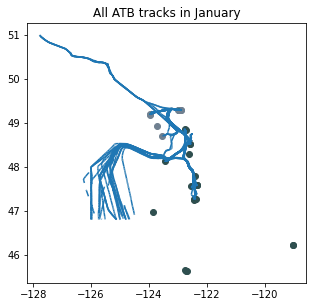

In [5]:
# plot the data using geopandas .plot() method
fig, ax = plt.subplots(figsize = (5,5))
atb_shp.plot(ax=ax)
plt.title('All ATB tracks in January')
plt.scatter(facBC["Longitude"],facBC["Latitude"], color='slategrey', marker='o')
plt.scatter(facWA["DockLongNumber"],facWA["DockLatNumber"], 
            color='darkslategrey', marker='o')
#plt.text(x=facBC["Longitude"],y=facBC["Latitude"], s=facBC['Name'].tolist())
plt.show()

### Plot up tracks for the six ATBs responsible for the most imports/exports


In [6]:
# extract information for particular MMSI
atb_shp_indv={}
for MMSI in MMSI_list:
    atb_shp_indv[MMSI] = atb_shp.loc[atb_shp['MMSI_NUM']==MMSI]

368013040
338616000


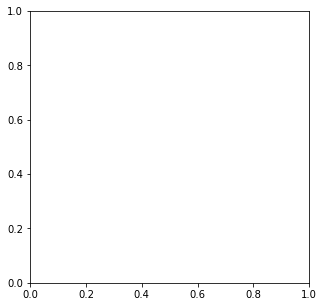

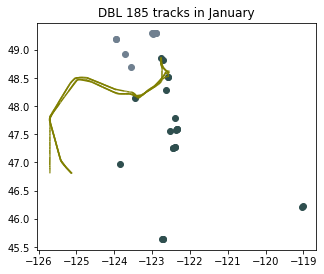

316001221


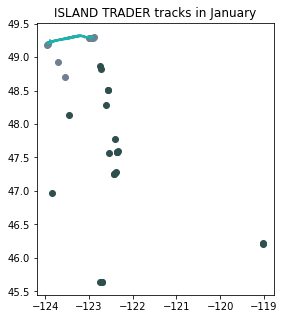

369580000


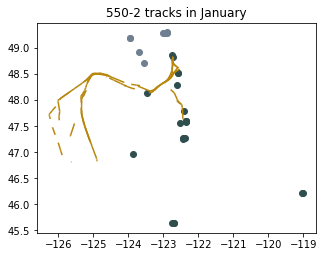

367740790


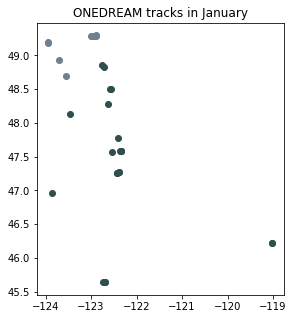

316001223


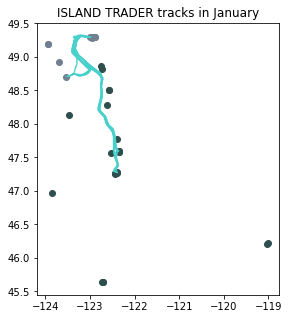

316006101


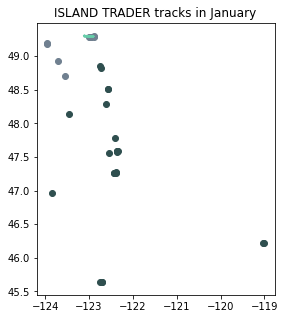

In [7]:
# plot the data using geopandas .plot() method
for MMSI in MMSI_list:
    print(MMSI)
    fig, ax = plt.subplots(figsize = (5,5))
    if atb_shp_indv[MMSI].empty==False:
        atb_shp_indv[MMSI].plot(ax=ax, color=color_dict[MMSI])
        plt.scatter(facBC["Longitude"],facBC["Latitude"], color='slategrey', marker='o')
        plt.scatter(facWA["DockLongNumber"],facWA["DockLatNumber"], 
                    color='darkslategrey', marker='o')
        plt.title(f'{MMSI_dict[MMSI]} tracks in January')
        plt.show()

## Create yearly data

In [8]:
%%time
atb_shp_path = {}
atb_shp={}

for months in range(1,13):
    #print(f'{months:02d}')
    # set file location and name
    atb_shp_path[months] = Path(f'/data/MIDOSS/shapefiles/atb_2018_{months:02d}.shp')

    # import shapefile using geopandas
    atb_shp[months] = gpd.read_file(atb_shp_path[months])
    
    if months == 1:
        print('creating shapefile for 2018, starting with January data')
        atb_shp_2018 = atb_shp[months]
    else:
        print(f'Concatenating data from month {months}')
        atb_shp_2018 = gpd.GeoDataFrame(pandas.concat([atb_shp_2018, atb_shp[months]]))
        


creating shapefile for 2018, starting with January data
Concatenating data from month 2
Concatenating data from month 3
Concatenating data from month 4
Concatenating data from month 5
Concatenating data from month 6
Concatenating data from month 7
Concatenating data from month 8
Concatenating data from month 9
Concatenating data from month 10
Concatenating data from month 11
Concatenating data from month 12
CPU times: user 37.4 s, sys: 916 ms, total: 38.3 s
Wall time: 39.3 s


### Evaluate DOE transfers  for ATBs with the largest number of transfers
- Transfers volumes are grouped and summed by `AntID` such that transfer quantity reflects ship cargo volume

In [42]:
top_dawgs = ['ITB ISLAND TRADER', 'ATB BARGE DBL 185', 'ATB BARGE ALL ABOARD FOR A CURE', 'ATB BARGE ONEDREAM', 'ATB BARGE 550-2']
[imports, exports]=get_DOE_atb(doe_xls_path, fac_xls_path, transfer_type = 'cargo', facilities='selected')

In [43]:
nbins = 20
max_transfer = 1e7 #note: ATB BARGE DBL 185 recorded 1 transfer as 5e7
bin_values = numpy.arange(0,max_transfer,max_transfer/20)
export_qty = {}
import_qty={}
for dawg in top_dawgs:
    print(dawg)
    export_qty[dawg]=exports.loc[
            exports.Receiver == dawg,
            ['TransferQtyInGallon','AntID']
        ].groupby('AntID').sum()
    import_qty[dawg]=imports.loc[
            imports.Deliverer == dawg,
            ['TransferQtyInGallon','AntID']
        ].groupby('AntID').sum()

ITB ISLAND TRADER
ATB BARGE DBL 185
ATB BARGE ALL ABOARD FOR A CURE
ATB BARGE ONEDREAM
ATB BARGE 550-2


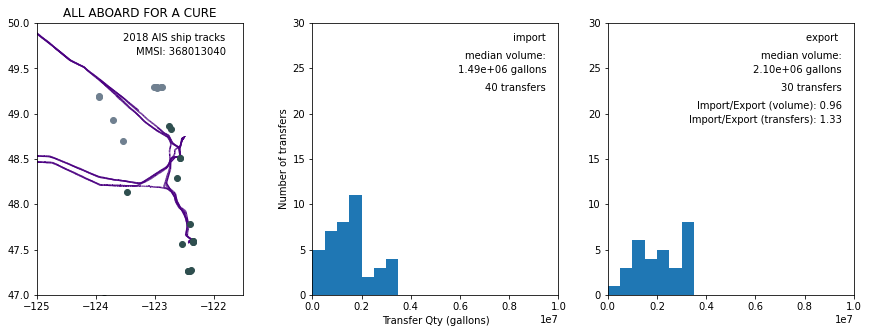

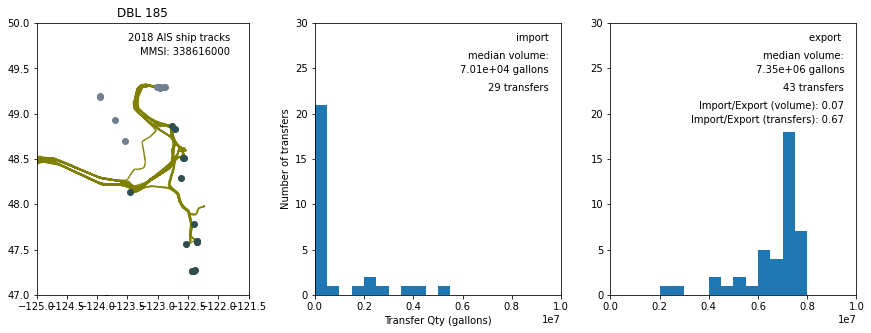

/home/rmueller/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rmueller/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


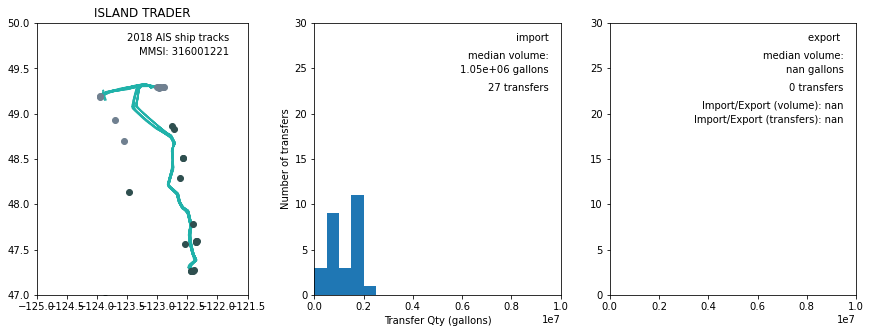

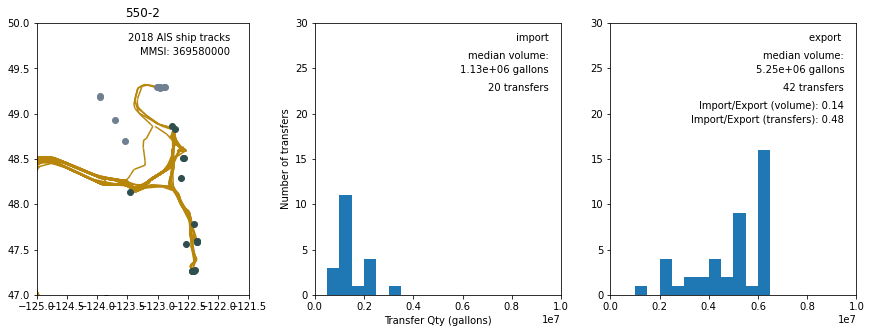

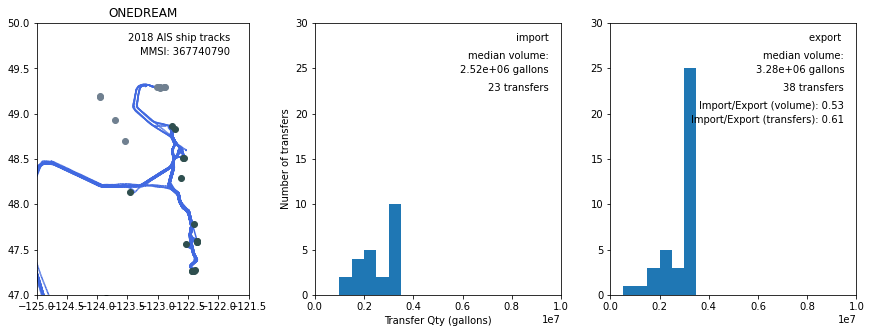

/home/rmueller/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rmueller/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


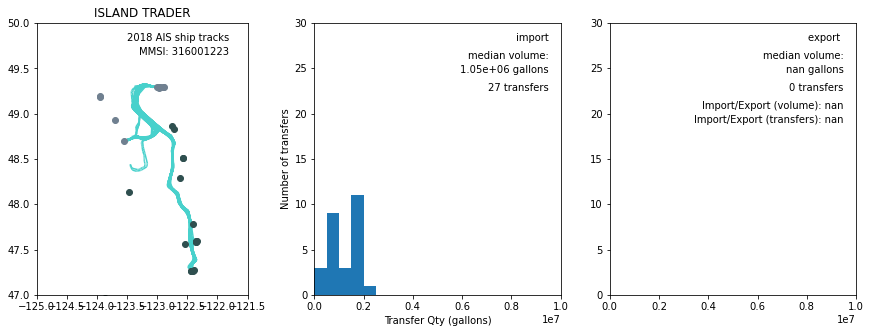

/home/rmueller/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rmueller/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


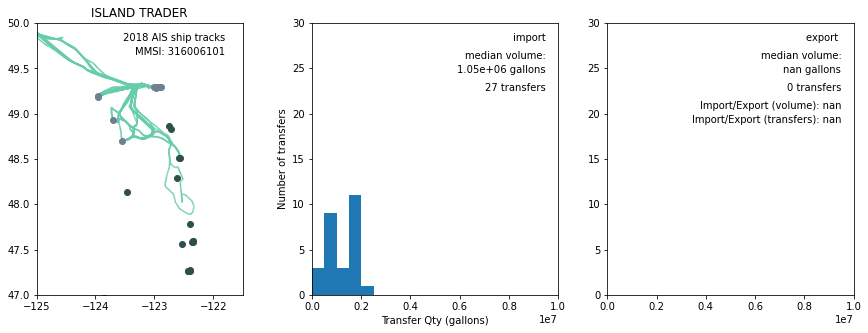

In [54]:
# extract information for particular MMSI
atb_shp_indv={}
for m_idx,MMSI in enumerate(MMSI_list):
    # Plot ship track data
    atb_shp_indv[MMSI] = atb_shp_2018.loc[atb_shp_2018['MMSI_NUM']==MMSI]
    # plot the data using geopandas .plot() method  
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    if atb_shp_indv[MMSI].empty==False:
        atb_shp_indv[MMSI].plot(ax=ax[0], color=color_dict[MMSI])
        ax[0].plot(
            facBC["Longitude"],facBC["Latitude"], 
            color='slategrey', marker='o', linestyle='None'
        )
        ax[0].plot(
            facWA["DockLongNumber"],facWA["DockLatNumber"], 
            color='darkslategrey', marker='o', linestyle='None'
        )
        ax[0].set_title(f'{MMSI_dict[MMSI]}')
        ax[0].set_xlim(-125,-121.5)
        ax[0].set_ylim(47,50)
    # Plot histograms for WA import and export transfers
    td_idx = [i for i, s in enumerate(top_dawgs) if MMSI_names[m_idx] in s]
    dawg = top_dawgs[td_idx[0]]
    # the histogram of the data
    n, bins, patches = ax[1].hist(import_qty[dawg],bins = bin_values)
    n, bins, patches = ax[2].hist(export_qty[dawg],bins = bin_values)
    ax[1].set_xlabel('Transfer Qty (gallons)')
    ax[1].set_ylabel('Number of transfers')
    # add useful information
    if len(export_qty[dawg]) > 0:
        qty_fraction = numpy.sum(import_qty[dawg]).item()/numpy.sum(export_qty[dawg]).item()
        transfer_fraction = len(import_qty[dawg])/len(export_qty[dawg])
    else:
        qty_fraction = numpy.NaN
        transfer_fraction = numpy.NaN
        
    ax[0].text(-121.8,49.8,'2018 AIS ship tracks', horizontalalignment='right')
    ax[0].text(-121.8,49.65,f'MMSI: {MMSI}', horizontalalignment='right')
#     ax[0].text(-121.8,49.50,f'Import/Export (volume): {qty_fraction:.2f}', horizontalalignment='right')
#     ax[0].text(-121.8,49.35,f'Import/Export (transfers): {transfer_fraction:.2f}', horizontalalignment='right')
    
    ax[1].text(max_transfer-.5e6,28,'import', horizontalalignment='right')
    ax[1].text(max_transfer-.5e6,26,'median volume:', horizontalalignment='right')
    ax[1].text(max_transfer-.5e6,24.5,f'{numpy.median(import_qty[dawg]):.2e} gallons', horizontalalignment='right')
    ax[1].text(max_transfer-.5e6,22.5,f'{len(import_qty[dawg])} transfers', horizontalalignment='right')
    
    ax[2].text(max_transfer-.5e6,28,'export ', horizontalalignment='right')
    ax[2].text(max_transfer-.5e6,26,'median volume:', horizontalalignment='right')
    ax[2].text(max_transfer-.5e6,24.5,f'{numpy.median(export_qty[dawg]):.2e} gallons', horizontalalignment='right')
    ax[2].text(max_transfer-.5e6,22.5,f'{len(export_qty[dawg])} transfers', horizontalalignment='right')
    ax[2].text(max_transfer-.5e6,20.5,f'Import/Export (volume): {qty_fraction:.2f}', horizontalalignment='right')
    ax[2].text(max_transfer-.5e6,19,f'Import/Export (transfers): {transfer_fraction:.2f}', horizontalalignment='right')
    
    for numax in [1,2]:
        ax[numax].set_ylim(0,30)
        ax[numax].set_xlim(0,max_transfer)
    plt.savefig(f'{MMSI}.png',bbox_inches='tight')
    plt.show()

In [52]:
qty_fraction

0.9622266401590457

### Plot all ATB traffic in 2018 to compare with tug traffic maps

In [ ]:
# plot the data using geopandas .plot() method
fig, ax = plt.subplots(figsize = (5,5))
atb_shp_2018.plot(ax=ax)
plt.title('ALL ATB tracks in 2018')
plt.scatter(facBC["Longitude"],facBC["Latitude"], color='slategrey', marker='o')
plt.scatter(facWA["DockLongNumber"],facWA["DockLatNumber"], 
            color='darkslategrey', marker='o')
plt.ylim(47,49.5)
plt.xlim(-124.75,-122)
#plt.text(x=facBC["Longitude"],y=facBC["Latitude"], s=facBC['Name'].tolist())
plt.show()

#### plot ATB tracks with different colors for "None", "Pacific", "Canada", "US"

In [ ]:
# create plotting dictionary for US and CAD marine terminals
US_attrs = dict((facility, ['grey','.']) for facility in facWA['FacilityName'])
CAD_attrs = dict((facility, ['grey','.']) for facility in facBC['Name'][0:10])
# create base-dictionary using generic attributions
# NOTE: I use "no data" here b/c None is ignored in groupby() and queries
plot_attrs = {'Pacific': ['lightseagreen','o'],
               'Canada': ['maroon','o'],
               'US': ['darkblue','o'],
               'No data' : ['green', 'o'],}
# combine all dictionaries
plot_attrs.update(US_attrs)
plot_attrs.update(CAD_attrs)

In [ ]:
# Need to convert None to "No data"
atb_shp_2018.loc[atb_shp_2018['TO'].isnull(), 'TO'] = 'No data' 

In [ ]:
# plot the ship tracks
fig, ax = plt.subplots(figsize  = (12, 8))

for ctype, data in atb_shp_2018.groupby('TO'):
    data.plot(color=plot_attrs[ctype][0], 
              label = ctype,
              ax = ax, 
             marker = plot_attrs[ctype][1],  
)

ax.legend(
    title="TO attribution",
    loc="upper left", 
    bbox_to_anchor=(1,1)
)
ax.set_title("ATB tracks by destination", fontsize=20)
ax.set_axis_off()
plt.ylim(47,49.5)
plt.xlim(-124.75,-122)
#plt.axis('equal')
plt.show()

### Plot tug traffic in January to get a sense for distribution of attributed and non-attributed tracks

In [ ]:
# set file location and name
barge_shp_path = Path('/data/MIDOSS/shapefiles/barge_2018_01.shp')

# import shapefile using geopandas
barge_shp = gpd.read_file(barge_shp_path)

# Need to convert None to "No data"
barge_shp.loc[barge_shp['TO'].isnull(), 'TO'] = 'No data' 

In [ ]:
barge_shp.head(2)

In [ ]:
# barge_shp_none = barge_shp.loc[
#     (barge_shp['TO']=='None') &
#     (barge_shp['FROM_']=='None')
# ]
# barge_shp_none.head(2)

In [ ]:
# plot the ship tracks
fig, ax = plt.subplots(figsize  = (12, 8))

for ctype, data in barge_shp.groupby('TO'):
    if ctype == 'US':
        data.plot(color=plot_attrs[ctype][0], 
                  label = ctype,
                  ax = ax, 
                 marker = plot_attrs[ctype][1],  
    )

ax.legend(
    title="TO attribution",
    loc="upper left", 
    bbox_to_anchor=(1,1)
)
ax.set_title("January barge tracks by destination", fontsize=20)
ax.set_axis_off()
plt.ylim(47,49.5)
plt.xlim(-124.75,-122)
#plt.axis('equal')
plt.show()

In [ ]:
# plot the ship tracks
fig, ax = plt.subplots(figsize  = (12, 8))

for ctype, data in barge_shp.groupby('TO'):
    if ctype == 'Canada':
        data.plot(color=plot_attrs[ctype][0], 
                  label = ctype,
                  ax = ax, 
                 marker = plot_attrs[ctype][1],  
    )

ax.legend(
    title="TO attribution",
    loc="upper left", 
    bbox_to_anchor=(1,1)
)
ax.set_title("January barge tracks by destination", fontsize=20)
ax.set_axis_off()
plt.ylim(47,49.5)
plt.xlim(-124.75,-122)
#plt.axis('equal')
plt.show()

In [ ]:
# plot the ship tracks
fig, ax = plt.subplots(figsize  = (12, 8))

for ctype, data in barge_shp.groupby('TO'):
    if ctype == 'Pacific':
        data.plot(color=plot_attrs[ctype][0], 
                  label = ctype,
                  ax = ax, 
                 marker = plot_attrs[ctype][1],  
    )

ax.legend(
    title="TO attribution",
    loc="upper left", 
    bbox_to_anchor=(1,1)
)
ax.set_title("January barge tracks by destination", fontsize=20)
ax.set_axis_off()
plt.ylim(47,49.5)
plt.xlim(-124.75,-122)
#plt.axis('equal')
plt.show()

In [ ]:
# plot the ship tracks
fig, ax = plt.subplots(figsize  = (12, 8))

for ctype, data in barge_shp.groupby('TO'):
    if ctype == 'No data':
        data.plot(color=plot_attrs[ctype][0], 
                  label = ctype,
                  ax = ax, 
                 marker = plot_attrs[ctype][1],  
    )

ax.legend(
    title="TO attribution",
    loc="upper left", 
    bbox_to_anchor=(1,1)
)
ax.set_title("January barge tracks by destination", fontsize=20)
ax.set_axis_off()
plt.ylim(47,49.5)
plt.xlim(-124.75,-122)
#plt.axis('equal')
plt.show()

In [ ]:
# plot the ship tracks
fig, ax = plt.subplots(figsize  = (12, 8))

for ctype, data in barge_shp.groupby('TO'):
    data.plot(color=plot_attrs[ctype][0], 
              label = ctype,
              ax = ax, 
             marker = plot_attrs[ctype][1],  
)

ax.legend(
    title="TO attribution",
    loc="upper left", 
    bbox_to_anchor=(1,1)
)
ax.set_title("January barge tracks by destination", fontsize=20)
ax.set_axis_off()
plt.ylim(47,49.5)
plt.xlim(-124.75,-122)
#plt.axis('equal')
plt.show()

In [ ]:
print(barge_shp['TO'].unique())

In [ ]:
# first is a nice way of looking at first values of groupby() result!
# barge_group = barge_shp.groupby('TO')
# barge_group.first()